In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

from scipy.io import loadmat
from scipy.optimize import minimize
from numpy.random import choice
from numpy.lib import pad
from math import sqrt, floor, ceil
from sklearn.linear_model import LogisticRegression

In [2]:
def load_data(file):
    return loadmat(file)

In [3]:
data = load_data('./ex3data1.mat')
X = data['X']
y = np.array(list(map(lambda a: [0] if a[0] == 10 else a, data['y'])))

print(X.shape)
print(y.shape)

(5000, 400)
(5000, 1)


### 1.2 Visualizing the data

In [4]:
def blockshaped(arr, nrows, ncols):
    """
    Return an array of shape (n, nrows, ncols) where
    n * nrows * ncols = arr.size

    If arr is a 2D array, the returned array looks like n subblocks with
    each subblock preserving the "physical" layout of arr.
    """
    h, w = arr.shape
    return (arr.reshape(h//nrows, nrows, -1, ncols)
               .swapaxes(1,2)
               .reshape(-1, nrows, ncols))


def unblockshaped(arr, h, w):
    """
    Return an array of shape (h, w) where
    h * w = arr.size

    If arr is of shape (n, nrows, ncols), n sublocks of shape (nrows, ncols),
    then the returned array preserves the "physical" layout of the sublocks.
    """
    n, nrows, ncols = arr.shape
    return (arr.reshape(h//nrows, -1, nrows, ncols)
               .swapaxes(1,2)
               .reshape(h, w))

In [5]:
def pad_with_ones(vector, pad_width, iaxis, kwargs):
    vector[:pad_width[0]] = 1
    vector[-pad_width[1]:] = 1
    return vector

In [6]:
def display_data(data):
    imgs = np.array([pad(data[i].reshape(20, 20).T, 1, pad_with_ones) for i in range(len(data))])
    
    m, height, width = imgs.shape
    n_row = floor(sqrt(m))
    n_col = ceil(m/n_row)
    
    imgs = unblockshaped(imgs, n_row*imgs.shape[1], n_col*imgs.shape[2])
    
    plt.gray()
    plt.imshow(imgs)

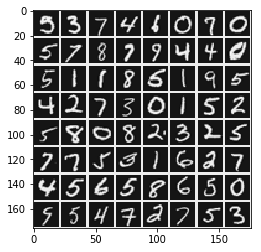

In [7]:
sample_data = X[choice(X.shape[0], 64, replace=False)]
# sample_data = X[0:64]
display_data(sample_data)

### 1.3 Vectorizing Logistic Regression

In [8]:
def sigmoid(x, derivative=False):
    return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [9]:
def lr_cost_function(theta, X, y, lamb):
    m = len(y)
    hx = sigmoid(theta.dot(X.T))
    J = (-1/m)*(y.T.dot(np.log(hx)) + (1-y).T.dot(np.log(1-hx))) + (lamb/(2*m))*np.sum(np.power(theta[1:],2))
    
    return J

In [10]:
def lr_gradient(theta, X, y, lamb):
    m = len(y)
    hx = sigmoid(X.dot(theta.reshape(-1,1)))
    grad = (1/m)*(hx-y).T.dot(X) + (lamb/m)*np.c_[[0], [theta[1:]]]
    
    return grad.flatten()

### 1.4 One-vs-all Classification

In [11]:
def one_vs_all(X, y, num_labels, lamb):
    all_theta = np.zeros((num_labels, X.shape[1]))
    for i in range(len(all_theta)):
        c_y = np.array(list(map(lambda a: [1] if a[0] == i else [0], y)))

        theta = all_theta[i]
        res = minimize(lr_cost_function, theta, method='BFGS', jac=lr_gradient, args=(X,c_y,lamb), options={'disp': True})
        all_theta[i] = res.x
        
    return all_theta

In [12]:
inception_X = np.c_[np.ones((X.shape[0],1)), X]
all_theta = one_vs_all(inception_X, y, 10, lamb=1)
print(all_theta.shape)

Optimization terminated successfully.
         Current function value: 0.020149
         Iterations: 179
         Function evaluations: 180
         Gradient evaluations: 180
Optimization terminated successfully.
         Current function value: 0.026961
         Iterations: 164
         Function evaluations: 165
         Gradient evaluations: 165
Optimization terminated successfully.
         Current function value: 0.068444
         Iterations: 208
         Function evaluations: 209
         Gradient evaluations: 209
Optimization terminated successfully.
         Current function value: 0.071707
         Iterations: 208
         Function evaluations: 209
         Gradient evaluations: 209
Optimization terminated successfully.
         Current function value: 0.052051
         Iterations: 203
         Function evaluations: 204
         Gradient evaluations: 204
Optimization terminated successfully.
         Current function value: 0.076859
         Iterations: 221
         Function ev

### 1.4.1 One-vs-all Prediction

In [13]:
def predict_one_vs_all(all_theta, X):
    return np.argmax(sigmoid(X.dot(all_theta.T)), axis=1)

In [14]:
def evaluate(ground_truth, prediction):
    return np.mean(ground_truth.ravel() == prediction)

In [15]:
prediction = predict_one_vs_all(all_theta, inception_X)
evaluate(y, prediction)

0.9446

### 2.1 Model representation

In [16]:
weights = load_data('./ex3weights.mat')
theta_1 = weights['Theta1']
theta_2 = weights['Theta2']
print(theta_1.shape)
print(theta_2.shape)

(25, 401)
(10, 26)


### 2.2 Feedforward Propagation and Prediction

In [17]:
def predict_nn(theta_1, theta_2, X):
    z2 = np.c_[np.ones((X.shape[0],1)), X].dot(theta_1.T)
    a2 = sigmoid(z2)

    z3 = np.c_[np.ones((a2.shape[0],1)), a2].dot(theta_2.T)
    a3 = sigmoid(z3)
    pred = np.argmax(a3, axis=1)+1
    
    return np.array(list(map(lambda x: 0 if x == 10 else x, pred)))

In [18]:
pred_nn = predict_nn(theta_1, theta_2, X)
evaluate(y, pred_nn)

0.9752

### Extra. sklearn implementation

In [19]:
clf = LogisticRegression(solver='newton-cg', max_iter=400, multi_class='auto').fit(X,y.ravel())
pred_clf = clf.predict(X)
evaluate(y, pred_clf)

0.9624